# Project Navigation -  Jordi Torres
## Deep Reinforcement Learning Nanodegree


### 1. Start the Environment
Type of GPU assigned:

In [1]:
!nvidia-smi

Tue Aug 18 13:55:15 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |     16MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import datetime
print("Starts at: ",datetime.datetime.now())

Starts at:  2020-08-18 13:55:15.238448


In [3]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.6 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States have length: 37


### 2. Model

Both Q-Networks (local and target) are implemented in _Pytorch_ by the class
**QNetwork**. This neural network has 3 fully-connected layers and 2 rectified nonlinear layers.


In [7]:
# Taken partially from 
# https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize parameters and build model.
        Params:
            state_size (int)   : Dimension of each state
            action_size (int)  : Dimension of each action
            seed (int)         : Random seed
            fc1_units (int)    : Number of nodes in first hidden layer
            fc2_units (int)    : Number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units) 
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

### 3. Agent
The class Agent implementing the following mechanisms: 
* Two Q-Networks (local and target) using the simple neural network.
* Replay memory (using the class ReplayBuffer)
* Epsilon-greedy mechanism
* Compute the Loss and update the Q-network weights using SGD mechanism (using the ADAM optimizer) 
* Update the weights of the target network 

In [8]:
# Taken partially from 
# https://github.com/udacity/deep-reinforcement-learning/blob/master/dqn/solution/dqn_agent.py

import numpy as np
import random
from collections import namedtuple, deque

#from model import QNetwork

import torch
import torch.nn.functional as F
import torch.optim as optim

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            fc1_units (int): fully connected layer 1 size
            fc2_units (int): fully connected layer 2 size
       """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed, fc1_units, fc2_units).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 4. Training

The _Deep-Q-Network_ procedure **dqn** performs the loop by _episodes_ till the number of episodes reached the maximal number of episodes `n_episodes=1800` or the completion criteria_ is executed `np.mean(scores_window) >= 13`. Internally **dqn** interacts with the **agent**.


In [9]:
import time
import math
import datetime
import torch                       
#from dqn_agent import Agent
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline 

def dqn(n_episodes=1800, eps_start=.99, eps_end=0.01, eps_decay = .994):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                                            # list of scores for each episode
    epsilon_list = []                                      # evolution of epsilon 
    
    scores_window = deque(maxlen=100)                      # last 100 scores
    eps = eps_start                                        

    for i_episode in range(1, n_episodes+1):              
        env_info = env.reset(train_mode = True)[brain_name]
        state = env_info.vector_observations[0]            # current state 
        score = 0                                          # reset the score counter for this episode
        done = False                                        
        while not done:                                    # internal loop in the episode until done
            action = agent.act(state,eps)                  # the agent takes the next action
            action = int(action)                           
            env_info = env.step(action)[brain_name]        # send the action to the environment
            
            next_state = env_info.vector_observations[0]   # get the next state from the environment
            reward = env_info.rewards[0]                   # get the reward from the environment
            done = env_info.local_done[0]                  # get the done (true if episode has finished) from the environment
            
            agent.step(state,action,reward,next_state, done) # next learning step by state and reward
            score += reward                                # count our rewards
            state = next_state                             # update state
            if done:                                       # done ?
                break                                      
        scores_window.append(score)                        # save score in the deque with 100 or less elements
        scores.append(score)
        
        eps = max(eps_end,eps_decay*eps)                   # decrease epsilon
        epsilon_list.append(eps)  
        
        count = 0                                          # Scores >= 13
        for j in range(len(scores_window)):                
            if scores_window[j] >= 13:
                count+=1
                
        
        print('\rEpisode: {}, Avg.Score: {:.2f},  Score {}, Scores >= 13: {}, Epsilon: {:.2f}'. \
            format(i_episode, np.mean(scores_window), score, count, eps), end="")
        
        if np.mean(scores_window) >=13:  # check completion criteria.
            print("\n terminating at episode :", i_episode, "ave reward reached +13 over 100 episodes")
            break
            
    return scores, i_episode, epsilon_list


Main Loop


In [10]:
print("Start training time: ",datetime.datetime.now())

# I tryed different number of nodes
fc1_nodes = 50
fc2_nodes = 40

agent = Agent(state_size=state_size, action_size=action_size, seed=1, fc1_units=fc1_nodes, fc2_units=fc2_nodes)

print("DQN architecture of the Agent:")
print (agent.qnetwork_local)
   
scores, episodes, epsilon_list = dqn(n_episodes = 1800, eps_start = 1.0)  # train with current params

print("End training time: ",datetime.datetime.now())

Start training time:  2020-08-18 13:56:10.390636
DQN architecture of the Agent:
QNetwork(
  (fc1): Linear(in_features=37, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=40, bias=True)
  (fc3): Linear(in_features=40, out_features=4, bias=True)
)
Episode: 450, Avg.Score: 13.03,  Score 15.0, Scores >= 13: 59, Epsilon: 0.07
 terminating at episode : 450 ave reward reached +13 over 100 episodes
End training time:  2020-08-18 14:05:44.148145


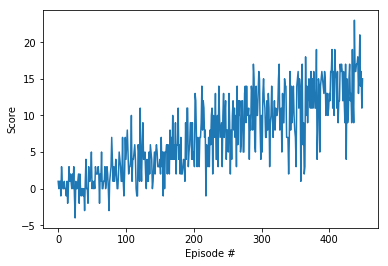

In [11]:
plt.plot(scores)
    
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

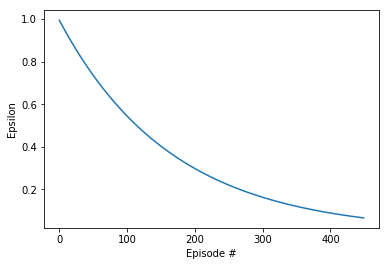

In [12]:
plt.plot(epsilon_list)
    
plt.ylabel('Epsilon')
plt.xlabel('Episode #')
plt.show()

### 5. Save the model

In [13]:
filename_to_save = 'model.pt'
torch.save(agent.qnetwork_local.state_dict(), filename_to_save)